Install and Import Dependencies

In [ ]:
%pip install mediapipe opencv-python

In [2]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils #drawing utilities
mp_pose = mp.solutions.pose #pose estimation model

In [11]:
cap = cv2.VideoCapture(0) #select the device
while cap.isOpened():
    ret, frame = cap.read() #get the frames
    cv2.imshow('Mediapipe Feed', frame) #popup video feed

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release() #release the device
cv2.destroyAllWindows() 

Make Detections

In [ ]:
cap = cv2.VideoCapture(0)
#Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read() #get the frames

        #Recolor image (OpenCV -> Mediapipe)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False #save memory

        #Make detection
        results = pose.process(image)

        #Recolor image back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        #Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(57,255,20),thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2)
                                  )

        cv2.imshow('Mediapipe Feed', image) #popup video feed

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release() #release the device
    cv2.destroyAllWindows() 

Extract Joint Coordinates

![mediapipe landmarks.png](<attachment:mediapipe landmarks.png>)
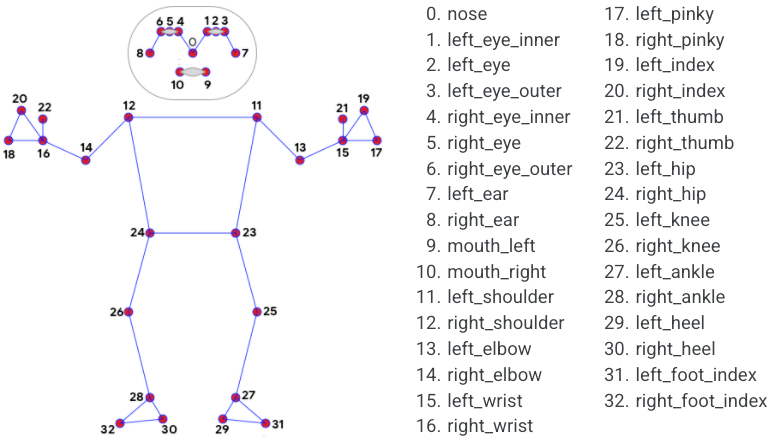

In [ ]:
cap = cv2.VideoCapture(0)
#Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read() #get the frames

        #Recolor image (OpenCV -> Mediapipe)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False #save memory

        #Make detection
        results = pose.process(image)

        #Recolor image back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        #Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            print(landmarks)
        except:
            pass

        #Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(57,255,20),thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2)
                                  )

        cv2.imshow('Mediapipe Feed', image) #popup video feed

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release() #release the device
    cv2.destroyAllWindows() 

In [ ]:
cap = cv2.VideoCapture(0)

goodform_flag = False

def calc_angle(p1, p2, p3):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    radians = np.arctan2(p1[1]-p2[1], p1[0]-p2[0]) - np.arctan2(p3[1]-p2[1], p3[0]-p2[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360-angle

    return np.round(angle, decimals=1)

#Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read() #get the frames

        #Recolor image (OpenCV -> Mediapipe)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False #save memory

        #Apply the pose model
        results = pose.process(image)

        #Recolor image back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        #Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            #Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

            #Calculate shoulder-hip slope
            slope = (shoulder[1]-hip[1])/(shoulder[0]-hip[0])

            if abs(slope) < 0.1:
                goodform_flag = True
                status_box_color = (0,255,0)
            else:
                goodform_flag = False
                status_box_color = (0,0,255)

            #Calculate hip angle
            angle = calc_angle(shoulder, hip, ankle)

            #Visualize hip angle
            cv2.putText(image, str(angle)+"deg",
                        tuple(np.multiply(hip, [1920, 1080]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2, cv2.LINE_AA
                        )

        except Exception as e:
            print(f"Error processing image: {e}")

        #Render goodform status box
        cv2.rectangle(image, (0,0), (225,80), status_box_color, -1)
        cv2.putText(image, 'GOOD FORM', (15,20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA
                    )
        cv2.putText(image, str(goodform_flag), (10,70),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA
                    )

        #Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(57,255,20),thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2)
                                  )

        cv2.imshow('Mediapipe Feed', image) #popup video feed

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release() #release the device
    cv2.destroyAllWindows() 